In [20]:
import os
import glob

import numpy as np
from skimage.io import imread
from skimage.transform import resize

import matplotlib.pyplot as plt

from tensorflow.keras.utils import normalize, to_categorical
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

Images are sorted into filders based on patient IDs. Each patient folder contains non-IDC and IDC image patches within subfolders named 0 and 1, respectively

In [2]:
img_folder='IDC_regular_ps50_idx5'
path = os.path.join(os.pardir, os.pardir, img_folder,'*','*')
paths = glob.glob(path)
paths[:10]

['..\\..\\IDC_regular_ps50_idx5\\10253\\0',
 '..\\..\\IDC_regular_ps50_idx5\\10253\\1',
 '..\\..\\IDC_regular_ps50_idx5\\10254\\0',
 '..\\..\\IDC_regular_ps50_idx5\\10254\\1',
 '..\\..\\IDC_regular_ps50_idx5\\10255\\0',
 '..\\..\\IDC_regular_ps50_idx5\\10255\\1',
 '..\\..\\IDC_regular_ps50_idx5\\10256\\0',
 '..\\..\\IDC_regular_ps50_idx5\\10256\\1',
 '..\\..\\IDC_regular_ps50_idx5\\10257\\0',
 '..\\..\\IDC_regular_ps50_idx5\\10257\\1']

In [3]:
# gethering image paths across folders and related data information from filename
# each element contain patiend_id, idx5, patch X coord, patch Y coord, class of patch ( 0 - non-IDK, 1 - IDK )

def list_of_data_images(img_folder='IDC_regular_ps50_idx5'):
    
    path = os.path.join(os.pardir, os.pardir, img_folder,'*','*','*')
    paths = glob.glob(path)

    str_preproc=[]
    for img_path in paths:
        img_name = os.path.basename(img_path)
        img_name = img_name.split('_')

        for i in range(2,len(img_name)):
            img_name[i] = int(''.join(filter(str.isdigit, img_name[i])))
        img_name.append(os.path.abspath(img_path))
        str_preproc.append(img_name)

    print(f"Number of data elements in list: {len(str_preproc)}")
    return str_preproc

The image patch filenames include the patient ID, a 5-digit index (idx5), the patch's X and Y coordinates, 
and the class of the patch (0 for non-IDC, 1 for IDC).

The function list_of_data_images gathers the paths to all image patches and creates a list of lists. 
Each element of the internal list contains information extracted from the patch filenames.

In [19]:
list_data_img = list_of_data_images()
print("Examples:")
rand_list = np.random.choice(len(list_data_img), 10)
for el in rand_list:
    print(f"{list_data_img[el]}")

Number of data elements in list: 277524
Examples:
['12823', 'idx5', 2751, 1801, 1, 'c:\\Users\\Igor\\DSI\\workspace\\team_project2\\IDC_regular_ps50_idx5\\12823\\1\\12823_idx5_x2751_y1801_class1.png']
['13400', 'idx5', 1351, 1201, 0, 'c:\\Users\\Igor\\DSI\\workspace\\team_project2\\IDC_regular_ps50_idx5\\13400\\0\\13400_idx5_x1351_y1201_class0.png']
['10254', 'idx5', 801, 1701, 0, 'c:\\Users\\Igor\\DSI\\workspace\\team_project2\\IDC_regular_ps50_idx5\\10254\\0\\10254_idx5_x801_y1701_class0.png']
['10273', 'idx5', 2201, 1701, 1, 'c:\\Users\\Igor\\DSI\\workspace\\team_project2\\IDC_regular_ps50_idx5\\10273\\1\\10273_idx5_x2201_y1701_class1.png']
['9226', 'idx5', 1251, 2401, 1, 'c:\\Users\\Igor\\DSI\\workspace\\team_project2\\IDC_regular_ps50_idx5\\9226\\1\\9226_idx5_x1251_y2401_class1.png']
['13916', 'idx5', 1001, 251, 0, 'c:\\Users\\Igor\\DSI\\workspace\\team_project2\\IDC_regular_ps50_idx5\\13916\\0\\13916_idx5_x1001_y251_class0.png']
['15516', 'idx5', 901, 1451, 0, 'c:\\Users\\Igor\\D

In [36]:
ind_nonIDC = np.where(np.asarray( list_data_img )[:,4] == '0' )
print (f"Number of non-IDC patches {len(ind_nonIDC[0])} ")
ind_IDC = np.where(np.asarray( list_data_img )[:,4] == '1' )
print (f"Number of IDC patches {len(ind_IDC[0])} ")


Number of non-IDC patches 198738 
Number of IDC patches 78786 


We have imbalanced classes, with IDC patches being the minority class. Therefore, we need to use stratification when splitting the data into training, validation, and test sets to ensure that the class distribution is preserved across all subsets.

In [128]:
def plot_pathes( est_class ):
    random_indices = np.random.choice(len(est_class), 18)

    fig, axes = plt.subplots(3, 6, figsize=(14, 9))
    for i, ax in enumerate(axes.flat):
        ax.imshow(imread(list_data_img[est_class[random_indices[i]]][5]), cmap=plt.cm.gray_r, interpolation='nearest')
        patient_id = list_data_img[est_class[random_indices[i]]][0]
        x_coord = list_data_img[est_class[random_indices[i]]][2]
        y_coord = list_data_img[est_class[random_indices[i]]][3]
        nonIDC = 'non-IDC' if list_data_img[est_class[random_indices[i]]][4] == 0 else 'IDC'
        ax.set_title(f"Patient:{patient_id},\nx: {x_coord}, y: {y_coord} \n {nonIDC}")

        ax.grid(False)
        
    plt.show()

 IDC patches - class '0' plot examples

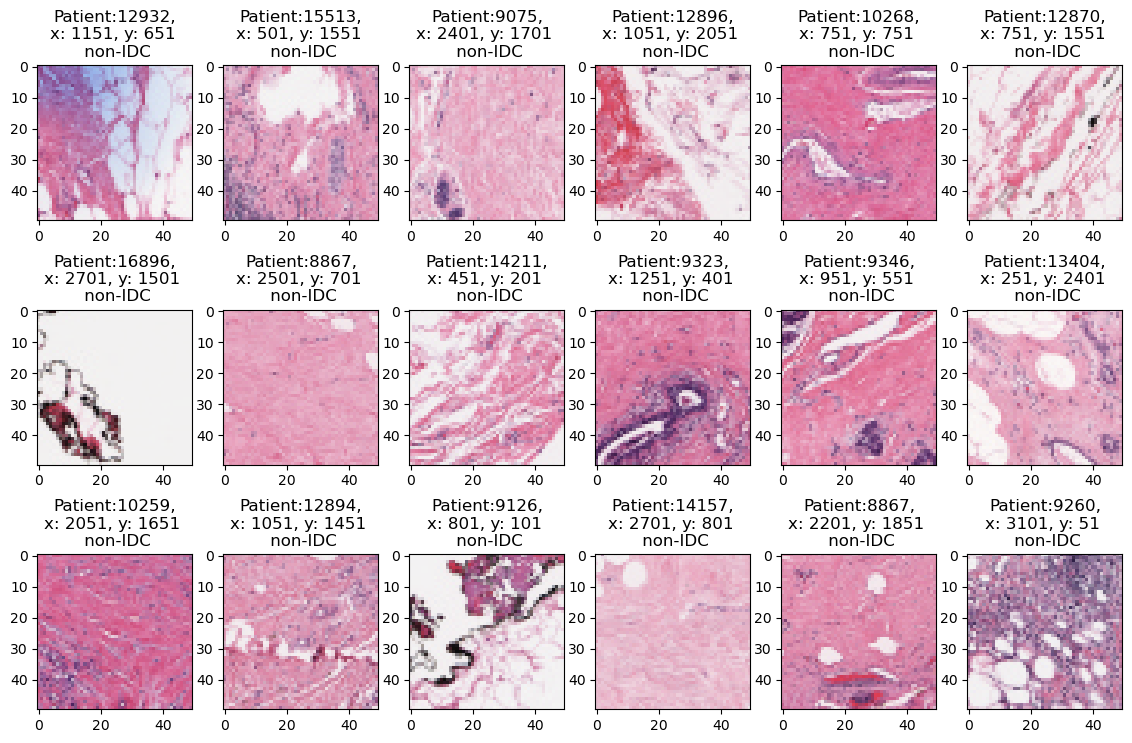

In [129]:
plot_pathes( ind_nonIDC[0] )

 IDC patches - class '1' plot examples

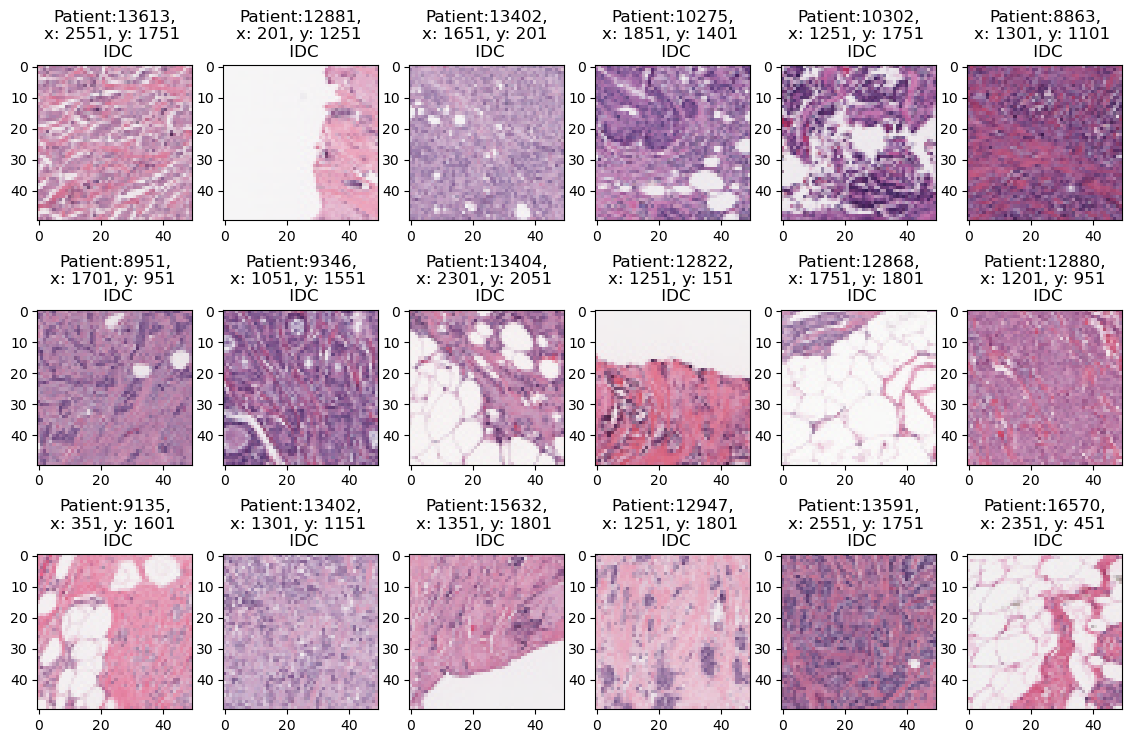

In [130]:
plot_pathes( ind_IDC[0] )

In [37]:
# convert images to 3 dim  numpy array

img_size = ( 50, 50 )
images_dataset = []
labels_dataset = []
for img in list_data_img:    
    image = np.asarray(imread(img[len(img)-1] ), dtype='i4' )
    if image.shape != (50, 50, 3):
        image = resize( image, img_size )                                     # resize images to given size and dimmensions
    images_dataset.append( image )                                            # images list in dimensions representation    
    labels_dataset.append( img[4])                                            # labels 0 - non cancer, 1 - cancer 

images_dataset = np.asarray( images_dataset, dtype='i4' )                     # convert to NumPy array
images_dataset = normalize( images_dataset )
labels_dataset = np.asarray(labels_dataset, dtype='i1')
print(f"\n Image data set shape: {images_dataset.shape}")
print(f"\n Labels data set shape: {labels_dataset.shape}")


 Image ds shape: (277524, 50, 50, 3)

 Labels ds shape: (277524,)


### Optinal step. 
### Save and load data to pkl file.

Saving preprocessed data allows us to load ready-to-use data without repeating the previous steps. By saving the data in parts, we can work more flexibly—using a few parts for implementation and debugging, or all parts for training purposes. 3-dimension patchs representation will be saved separately from information.

In [136]:
import pickle

# Save the array to a pickle file
# images_dataset - NumPy dataset
# parts - split to save in separated files. More parts less memory need 
def SaveNpToPkl( filename, images_dataset, parts = 1 ):
    start_ind = 0
    step = images_dataset.shape[0] // parts
    for i in range(0, parts):
        filename_pkl = filename + str(i) +'.pkl'
        start_ind = step*i
        if i != parts-1:
            end_ind = step*(i+1) 
        else:
            end_ind = images_dataset.shape[0] 
    
        print( f" Dataset with indexes {start_ind}, {end_ind} saved to file {filename_pkl}" )
        with open(filename_pkl, 'wb') as f:
            pickle.dump(images_dataset[start_ind : end_ind], f)

# Load the array from the pickle file
# parts - parts to load
def LoadPklToNp( filename, parts=1 ):
    total_list = []
    paths = glob.glob(filename)
    for path in paths[:parts]:
        print(f"Loading file {path}")
        with open(path, 'rb') as f:
            part_array = pickle.load(f)
        total_list += list(part_array)
        #total_list = np.concatenate(( total_array, array), axis=0 )
    return total_list


In [25]:
# call numpy to pkl save func.

# Specify relative path and the filename
parts = 10
filename = os.path.join( os.pardir, 'data', 'processed', 'img_dataset')
SaveNpToPkl( filename, images_dataset, parts )

filename = os.path.join( os.pardir, 'data', 'processed', 'lables_data')
SaveNpToPkl( filename, np.asarray(list_data_img), parts )

 Dataset with indexes 0, 27752 saved to file ..\data\processed\img_dataset0.pkl
 Dataset with indexes 27752, 55504 saved to file ..\data\processed\img_dataset1.pkl
 Dataset with indexes 55504, 83256 saved to file ..\data\processed\img_dataset2.pkl
 Dataset with indexes 83256, 111008 saved to file ..\data\processed\img_dataset3.pkl
 Dataset with indexes 111008, 138760 saved to file ..\data\processed\img_dataset4.pkl
 Dataset with indexes 138760, 166512 saved to file ..\data\processed\img_dataset5.pkl
 Dataset with indexes 166512, 194264 saved to file ..\data\processed\img_dataset6.pkl
 Dataset with indexes 194264, 222016 saved to file ..\data\processed\img_dataset7.pkl
 Dataset with indexes 222016, 249768 saved to file ..\data\processed\img_dataset8.pkl
 Dataset with indexes 249768, 277524 saved to file ..\data\processed\img_dataset9.pkl


In [3]:
# call pkl loader
parts_load = 5
Load_path = os.path.join( os.pardir, 'data', 'processed', 'img_dataset*' )
images_dataset = np.asarray ( LoadPklToNp( Load_path, parts_load ), dtype='float32')

Load_path = os.path.join( os.pardir, 'data', 'processed', 'lables_data*' )
labels_dataset = np.asarray(np.asarray (LoadPklToNp( Load_path, parts_load ) )[:, 4:5], dtype='i1' )                   # [:, 4:5] - retrive only label values from load data set

Loading file ..\data\processed\img_dataset0.pkl
Loading file ..\data\processed\img_dataset1.pkl
Loading file ..\data\processed\img_dataset2.pkl
Loading file ..\data\processed\img_dataset3.pkl
Loading file ..\data\processed\img_dataset4.pkl
Loading file ..\data\processed\lables_data0.pkl
Loading file ..\data\processed\lables_data1.pkl
Loading file ..\data\processed\lables_data2.pkl
Loading file ..\data\processed\lables_data3.pkl
Loading file ..\data\processed\lables_data4.pkl


Transform 1 dimension labels to 2 dim target ( input ) shape

In [109]:
cat_labels = to_categorical( labels_dataset, num_classes=2 )
cat_labels = cat_labels.astype('i1')
cat_labels

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=int8)

We are splitting the data into 20% for validation, 20% of the remaining 80% for testing, and the rest for training.

In [110]:
x_train, x_val, y_train, y_val = train_test_split( images_dataset, cat_labels, test_size=0.20, stratify=labels_dataset, random_state=42)
x_train, x_test, y_train, y_test = train_test_split( x_train, y_train, test_size=0.20, stratify=y_train, random_state=42)

In [111]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((200510, 50, 50, 3), (41629, 50, 50, 3), (200510, 2), (41629, 2))

Plot graphs for train, test, and validation datasets to check if the data split is balanced.

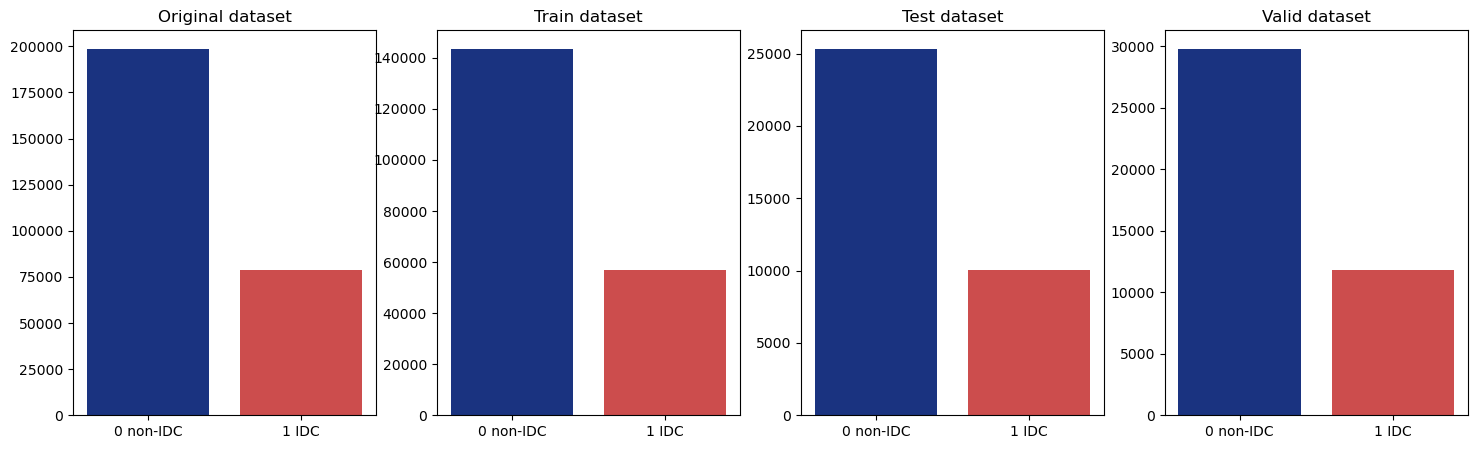

In [203]:
# Plot histogram for balanc labels
data_set_list = [ cat_labels, y_train, y_test, y_val ]
data_set_names = ['Original dataset','Train dataset','Test dataset','Valid dataset']
fig, ax = plt.subplots(1, 4, figsize=(18,5))
for i, ax in enumerate(ax.flat): 
    class_counts = [data_set_list[i][:,0].sum(), data_set_list[i][:,1].sum()]
    ax.bar(['0 non-IDC', '1 IDC'], class_counts, color=[(0.1, 0.2, 0.5), (0.8, 0.3, 0.3)])
    ax.set_title(data_set_names[i])
plt.show()

Histograms for the train, test, and validation datasets show class distributions that closely match the distribution of the original dataset. This means that the proportions of 0 non-IDC and 1 IDC in the training, testing, and validation datasets are similar to those in the original dataset, indicating that the split was done proportionally.

In [137]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score
from keras.losses import BinaryCrossentropy

def model_init( optimazer, learn_rate=None, activation=None, kernel_initializer=None, strading=1, inp_multip=1, drop_perc=0.1 ):
    model = Sequential([
        Conv2D( filters=32*inp_multip, kernel_size=(3, 3), activation=activation, kernel_initializer=kernel_initializer, padding="same" ),  
        MaxPooling2D(2),    
        Conv2D( filters=64*inp_multip, kernel_size=(3, 3), activation=activation, padding="same" ),  
        MaxPooling2D(2),    
        BatchNormalization(),

        Conv2D( filters=128*inp_multip, kernel_size=(3, 3), activation=activation, kernel_initializer=kernel_initializer, padding="same" ),  
        MaxPooling2D(2),    
        Conv2D( filters=128*inp_multip, kernel_size=(3, 3), activation=activation, padding="same" ),  
        MaxPooling2D(2),    
        BatchNormalization(),

        Flatten(),
        Dropout(drop_perc),
        Dense( 128*inp_multip, activation='relu'),        
        Dropout(drop_perc),
        Dense( 64*inp_multip, activation='relu'),         
        Dropout(drop_perc),   
        Dense( 32*inp_multip, activation='relu'),
        Dense( 2, activation='softmax' )
    ])

    model.compile( loss='binary_crossentropy', optimizer=optimazer(learning_rate=learn_rate), metrics=['accuracy'])

    return model

In [ ]:
param_grid = {       
    'inp_multip': [1, 2, 3], 
    'optimazer': [optimizers.Adam, optimizers.Nadam, optimizers.SGD],
    'learn_rate': [None, 0.0001, 0.001],
    'strading': [1, 2],
    'kernel_initializer': [None, 'he_uniform'],
    'learn_rate': [None, 'relu'],    
    'drop_perc': [0.1, 0.3, 0.5],
}

model = KerasClassifier(build_fn=model_init, verbose=0)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy' )
grid_result = grid.fit(x_train, y_train, epochs=10, shuffle=True, batch_size=70, validation_data=(x_val, y_val) )